<a href="https://colab.research.google.com/github/RedBatProject/Thesis---a-two-layer-power-network/blob/main/Doing_thesis_sep3_1th.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# All the imports here

In [1]:
%pip install pandapower
import pandapower as pp
import networkx as nx
import pandapower.networks as pn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandapower.topology as top
# import networkx as nx
from pandapower import plotting
from pandapower.plotting import simple_plot, pf_res_plotly,simple_plotly
import random as rn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numba
# plt.rcParams['figure.dpi'] = 100
# plt.rcParams['savefig.dpi'] = 100

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 20.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.9/70.9 kB 7.5 MB/s eta 0:00:00
  Created wheel for pandapower: filename=pandapower-2.13.1-py3-none-any.whl size=10803675 sha256=36db9172af540e0af55f8f623d9cad769b2c886154800c8e15046bf77f2171f6
  Stored in directory: /root/.cache/pip/wheels/6b/58/fb/c5c16044f0046e905e2fe55de3af6c0a43bfcc3219ed5d3af8
Successfully built pandapower


In [2]:
import time

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
seed = 1537
alpha = 0.39
beta = 0.1
gamma = 1-(alpha + beta)
alpha,beta,gamma
np.random.seed(seed)


nodes=101
k=4
# seed=seed
# np.random.seed(seed)

p=0.2
types=0
# G = nx.watts_strogatz_graph(nodes,k,p=p,seed=seed)
# edges = list(G.edges())

# The Code

In [6]:
def set_of_nodes_by_list(numer_of_nodes,of_set,num_iter,seed):
    np.random.seed(seed)
    P_ = list()
    while len(P_) < num_iter:
        p_ = list()
        f_ = int(numer_of_nodes * of_set)
        while len(p_) < f_:
            f1_ = np.random.randint(0,numer_of_nodes)
            if f1_ not in p_ and f1_ != target:
                p_.append(f1_)
        P_.append(p_)
    return np.array(P_)

def remove_by_fraction(numer_of_nodes,of_set):
    p_ = list()
    f_ = int(numer_of_nodes * of_set)
    while len(p_) < f_:
        f1_ = np.random.randint(0,numer_of_nodes)
        if f1_ not in p_ and f1_ != target:
            p_.append(f1_)
    return p_

def remove_by_number(numer_of_nodes,of_set):
    p_ = list()
    f_ = int(of_set)
    while len(p_) < f_:
        f1_ = np.random.randint(0,numer_of_nodes)
        if f1_ not in p_ and f1_ != target:
            p_.append(f1_)
    return p_

# define set of nodes which you want to remove
def set_of_nodes(numer_of_nodes,of_set):
    if of_set <= 1:
        p_frac = remove_by_fraction(numer_of_nodes,of_set)
    if of_set > 1:
        p_frac = remove_by_number(numer_of_nodes,of_set)
    return np.array(p_frac)




In [8]:
# Ok, we have a Net, no we want to create the communication network, for this we use our written model from before
def create_net(net):
    # np.random.seed(seed)

    Net = net
    G_power = top.create_nxgraph(net=Net)
    # extract some feature for future
    G_power_nodes = G_power.nodes()
    G_power_nodes_Number = len(G_power_nodes)
    G_power_edges = G_power.edges()
    target = int(Net.ext_grid['bus'][0])
    Static_node_of_power = len(Net.bus)
    G_scale_free = nx.scale_free_graph(n= Static_node_of_power, alpha= alpha, beta= beta, gamma= gamma, seed= seed, delta_in=1, delta_out=1 )
        # create Com from Scale free
    # print(set(G_scale_free.nodes()))
    G_com_edges = G_scale_free.edges()
    G_com_edges_set = set(G_com_edges)
    G_com_edges_set_non_redundancy = []
    # print(set(G_com.nodes()))
    for G_edge in G_com_edges_set:
        if (G_edge[1],G_edge[0]) and (G_edge[0],G_edge[1]) not in G_com_edges_set_non_redundancy:
            if G_edge[1] != G_edge[0]:
                G_com_edges_set_non_redundancy.append(G_edge)
    G_com = nx.MultiGraph()
    # print(set(G_com.nodes()))
    G_com.add_edges_from(G_com_edges_set_non_redundancy);
    if len(set(G_scale_free.nodes() - set(G_com.nodes))) > 0:
        for ij in list(set(G_scale_free.nodes() - set(G_com.nodes))):
            G_com.add_edges_from([(ij,np.random.randint(len(G_power.nodes())))])
    # print(set(G_com.nodes()))
        # add a few work to this
    mapping = {0:target,target:0}
    G_com = nx.relabel_nodes(G_com, mapping)

        # extract initial information
    G_com_nodes = G_com.nodes()
    # print(set(G_com.nodes()))
    G_com_edges = G_com.edges()
    # print("Networks settings are Done!")
    return G_com,Net,G_power,target,G_power_nodes_Number

In [39]:
# we sould find the largest component
# we use this code from networkx
def Largest_component_with_target(G,target_node):
    # np.random.seed(seed)

    # check the largest components
    components_of_groph = sorted(nx.connected_components(G), key=len, reverse=True)
    for component in components_of_groph:
        if target_node in component:
            G = G.subgraph(component)
            G = nx.MultiGraph(G)
    return G

In [863]:
# Again we write a code for casecading failure in this time
# here are what we should do
# 1: drop the removed_nodes from power network
# 2: drop the coupled_nodes from communication network
# 3: modify the power network
# 4: let the casecade goes and see where it could go
# 5: evaluate

# initiate the p_frac
def phase_0(p_frac):
    # print('im in phase 0')
    if len(p_frac) == 0:
        # self.node = instance_nodes - nodes
        busses = []
    elif len(p_frac) == 1:
        busses = p_frac
    else:

        busses = list(p_frac)
    return busses


# first time removing nodes
def phase_0_1(Net,busses):
    # print('im in phase 0_1')
    # try:
    pp.drop_buses(Net,buses=busses,drop_elements = True)
    # except:print('[SOMETHING HAPPENED!]')
    return Net
# removing nodes from power network
def phase_1(Net):
    # print('im in phase 1')
    # we run power for the first time
    pp.rundcpp(Net)
    # drop all droped element relevants
    drop_lines = pp.overloaded_lines(Net)
    # drop the lines
    pp.drop_lines(Net,drop_lines)
    # create a nx network from power network
    g_inst_power = top.create_nxgraph(Net)
    # look for largest copunent
    g_inst_2_power = Largest_component_with_target(g_inst_power,target)
    # which nodes are remvoved from network?
    set_nodes_2 = set(g_inst_power) - set(g_inst_2_power)
    pp.drop_buses(Net,set_nodes_2,drop_elements = True)
    return Net,g_inst_2_power,set_nodes_2

# now we know what nodes from communication part should get remove
def phase_2(G_com,to_com):
    # print('im in phase 2')
    G_com.remove_nodes_from(to_com)
    g_inst_2 = Largest_component_with_target(G_com,target)
    set_nodes_2 = set(G_com.nodes) - set(g_inst_2.nodes)
    return g_inst_2,set_nodes_2

# now the modification part (no 1)
# def phase_3(net,gen_frac,pow_frac,is_not_in):
#     print('max_gen: {} now_gen: {} max_load: {} now_load: {}'.format(max_gen,np.sum(net['gen']['p_mw']),max_load,np.sum(net['load']['p_mw'])))
#     # print('im in phase 3')
#     imp_gen = list(net.gen['p_mw'].sort_values(ascending=False).index)
#     if gen_frac <= 1:
#         s_number = int(len(imp_gen) * gen_frac)
#     else:
#         s_number = int(gen_frac)
#     # for i in imp_gen[0:s_number]:
#     for i in range(0,s_number):
#         if i not in is_not_in:
#             # print(i)
#             # print(imp_gen)
#             # print(imp_gen[i])
#             net.gen['p_mw'].loc[imp_gen[i]] *= 1 + pow_frac
#             # print(f"oh, {i} is modified!")
#         else:
#             pass
#             # print("cant modify {} cause we cant reach it".format(i))
#     print('max_gen: {} now_gen: {} max_load: {} now_load: {}'.format(max_gen,np.sum(net['gen']['p_mw']),max_load,np.sum(net['load']['p_mw'])))
#     print('---------------------------')
#     return net


# # now the modification part (no 2)
# def phase_3(net,gen_frac,pow_frac,is_not_in):
#     is_canceled = False
#     pow_frac = 0
#     # print('max_gen: {} now_gen: {} max_load: {} now_load: {}'.format(max_gen,np.sum(net['gen']['p_mw']),max_load,np.sum(net['load']['p_mw'])))
#     # print('now_res_gen: {} now_res_load: {}'.format(np.sum(net['res_gen']['p_mw']),np.sum(net['res_load']['p_mw'])))
#     if gen_frac > 0:
#         imp_gen = list(net.gen['p_mw'].sort_values(ascending=False).index)
#         if gen_frac <= 1:
#             s_number = int(len(imp_gen) * gen_frac)
#         else:
#             s_number = int(gen_frac)
#         pp.rundcpp(net)
#         # ---------------------------------------------------
#         # modification based on what we need and not what we want
#         what_we_need = np.sum(net['res_gen']['p_mw']) - np.sum(net['res_load']['p_mw'])
#         print("what we have: ",what_we_need)
#         # -----------------------------------------------------
#         # imp_gen = list(net.gen['p_mw'].sort_values(ascending=False).index)
#         # -----------------------------------------------------
#         # if we have more power then we should lower the total power in all gens
#         if np.sum(net['gen']['p_mw']) > 0:
#             if what_we_need > 0: #this means we have more power than we need, so we should remove some of it
#                 soap = 0
#                 for i in range(0,s_number):
#                     if i not in is_not_in:
#                         soap += net.gen['p_mw'].loc[imp_gen[i]]
#                 try:
#                     pow_frac =   - what_we_need / soap
#                 except:
#                     pow_frac = 0
#                 print('we will reduce it by {}'.format(pow_frac))
#                 print(f"when its positive {what_we_need=} {np.sum(net['gen']['p_mw'])}")
#                 print(net['res_ext_grid']['p_mw'][0])

#             else: #this means we have more need than what we have already, so we need to make more power
#                 # pass
#                 print(f"when its negative {what_we_need=} {np.sum(net['gen']['p_mw'])}")
#                 print(net['res_ext_grid']['p_mw'][0])




#                 offline = net['ext_grid']['max_p_mw'][0] - net['res_ext_grid']['p_mw'][0]
#                 what_we_need += offline
#                 print(f"when we add ext {what_we_need=} {np.sum(net['gen']['p_mw'])}")
#                 print(net['res_ext_grid']['p_mw'][0])
#                 if what_we_need < 0:


#                     pow_frac =   - what_we_need / np.sum(net['gen']['p_mw'])
#                     print('we will add it by {}'.format(pow_frac))
#                     print(net['res_ext_grid']['p_mw'][0])

#                 else:
#                     pass
#                 print('we will add it by {}'.format(pow_frac))
#         else:
#             print('fraction is zero',np.sum(net['gen']['p_mw']),imp_gen)
#             pow_frac = 0
#         if pow_frac > 0.1:
#             print(f'{pow_frac=}')
#             pow_frac = 0


#         # if gen_frac <= 1:
#         #     s_number = int(len(imp_gen) * gen_frac)
#         # else:
#         #     s_number = int(gen_frac)
#         # for i in imp_gen[0:s_number]:
#         if pow_frac !=0:
#             for i in range(0,s_number):
#                 # pow_frac = 5 #########################################################################
#                 if i not in is_not_in:
#                     before = net.gen['p_mw'].loc[imp_gen[i]]
#                     net.gen['p_mw'].loc[imp_gen[i]] *= 1 + pow_frac
#                     now = net.gen['p_mw'].loc[imp_gen[i]]
#                     # print(f"oh, {i} is modified! {before} {now}")
#                 else:
#                     pass
#                     # print("cant modify {} cause we cant reach it".format(i))
#         pp.rundcpp(net)
#         if net['res_ext_grid']['p_mw'][0] >= net['ext_grid']['max_p_mw'][0] or net['res_ext_grid']['p_mw'][0]<-10:
#             print('0: model is canceled du to {} {}'.format(net['res_ext_grid']['p_mw'][0],net['ext_grid']['max_p_mw'][0]))
#             is_canceled = True
#         what_we_need = np.sum(net['res_gen']['p_mw']) - np.sum(net['res_load']['p_mw'])
#         # print("what we reached: ",what_we_need)
#         return net,is_canceled
#     else:
#         pp.rundcpp(net)
#         if net['res_ext_grid']['p_mw'][0] >= net['ext_grid']['max_p_mw'][0] or net['res_ext_grid']['p_mw'][0]<-10:
#             print('1: model is canceled du to {} {}'.format(net['res_ext_grid']['p_mw'][0],net['ext_grid']['max_p_mw'][0]))
#             is_canceled = True
#         # print('bare foot')
#         return net,is_canceled

# now the modification part (no 3)
def phase_3(net,gen_frac,pow_frac,is_not_in):
    is_canceled = False
    pow_frac = 0
    # print('max_gen: {} now_gen: {} max_load: {} now_load: {}'.format(max_gen,np.sum(net['gen']['p_mw']),max_load,np.sum(net['load']['p_mw'])))
    # print('now_res_gen: {} now_res_load: {}'.format(np.sum(net['res_gen']['p_mw']),np.sum(net['res_load']['p_mw'])))
    if gen_frac > 0:
        imp_gen = list(net.gen['p_mw'].sort_values(ascending=False).index)
        if gen_frac <= 1:
            s_number = int(len(imp_gen) * gen_frac)
        else:
            s_number = int(gen_frac)
        pp.rundcpp(net)
        # ---------------------------------------------------
        # modification based on what we need and not what we want
        what_we_need = net['ext_grid']['max_p_mw'][0] - net['res_ext_grid']['p_mw'][0]
        # print("what we have: ",what_we_need)
        # -----------------------------------------------------
        # imp_gen = list(net.gen['p_mw'].sort_values(ascending=False).index)
        # -----------------------------------------------------
        # if we have more power then we should lower the total power in all gens
        if np.sum(net['gen']['p_mw']) > 0:
            if what_we_need > 0: #this means we have more power than we need, so we should remove some of it
                # print(f'{what_we_need=} so its positive there is no error unless...')
                if net['res_ext_grid']['p_mw'][0] < 0: #what this means? external grid its cunsuming ints not true
                    # print(f"{net['res_ext_grid']['p_mw'][0]} so its negative we should lower the power")
                    pow_frac = (net['res_ext_grid']['p_mw'][0]/np.sum(net['gen']['p_mw'])) * 1.5
            else:
                # when its negative its mean that ext should make more power than it can so others should help it
                # print(f'{what_we_need=} so its negative? we should make more power')
                pow_frac = -(what_we_need/ np.sum(net['gen']['p_mw'])) * 1.2

        else:
            print('fraction is zero',np.sum(net['gen']['p_mw']),imp_gen)
            pow_frac = 0
        if pow_frac > 0.2:
            # print(f'{pow_frac=}')
            pow_frac = 0.2

        if pow_frac !=0:
            for i in range(0,s_number):
                # pow_frac = 5 #########################################################################
                # if i not in is_not_in:
                try:
                    before = net.gen['p_mw'].loc[imp_gen[i]]
                    net.gen['p_mw'].loc[imp_gen[i]] *= 1 + pow_frac
                    now = net.gen['p_mw'].loc[imp_gen[i]]
                    # print(f"oh, {i} is modified! {before} {now}")
                except:pass
                # else:
                    # pass
                    # print("cant modify {} cause we cant reach it".format(i))
        pp.rundcpp(net)
        if net['res_ext_grid']['p_mw'][0] >= net['ext_grid']['max_p_mw'][0] or net['res_ext_grid']['p_mw'][0]<-10:
            print('0: model is canceled du to {} {}'.format(net['res_ext_grid']['p_mw'][0],net['ext_grid']['max_p_mw'][0]))
            is_canceled = True
        what_we_need = np.sum(net['res_gen']['p_mw']) - np.sum(net['res_load']['p_mw'])
        # print("what we reached: ",what_we_need)
        return net,is_canceled
    else:
        pp.rundcpp(net)
        if net['res_ext_grid']['p_mw'][0] >= net['ext_grid']['max_p_mw'][0] or net['res_ext_grid']['p_mw'][0]<-10:
            print('1: model is canceled du to {} {}'.format(net['res_ext_grid']['p_mw'][0],net['ext_grid']['max_p_mw'][0]))
            is_canceled = True
        # print('bare foot')
        return net,is_canceled


# now we should continue the casecading failure
def phase_4(Net,G_power,G_com):
    # print('im in phase 4')
    Net,G_power,to_com = phase_1(Net)
    while len(list(to_com)) != 0:
        Net,G_power,to_com = phase_1(Net)
        # print(to_com)
        # G_com,to_power = phase_2(G_com,to_com)
    return Net,G_power,G_com
def casecading_version_2(Net,G_com,G_power,p_frac,fraction_gen,fraction_power):
    nodes_from_both = {'power':set(G_power.nodes),'communication':set(G_com.nodes),'disabled':set()}

    busses = phase_0(p_frac)
    # remove nodes from power
    Net = phase_0_1(Net,busses)
    # remove nodes from power network
    Net,G_power,to_com = phase_1(Net)
    # set the power reminded node
    nodes_from_both['power'] = set(G_power.nodes)
    # we should remove them from communiaction network too
    if len(list(to_com)) != 0:
        # remove nodes from communication network
        G_com,to_power = phase_2(G_com,to_com)
        # set the communication reminded nodes
        nodes_from_both['communication'] = set(G_com.nodes)
        # set the disabled nodes
        nodes_from_both['disabled'] = nodes_from_both['communication'] - nodes_from_both['power']
        # modification
        Net,is_canceled_ = phase_3(Net,fraction_gen,fraction_power,nodes_from_both['disabled']) #its No 3
        Net,G_power,G_com = phase_4(Net,G_power,G_com)
        return Net,G_power,G_com,is_canceled_
    else:
        return Net,G_power,G_com,False





In [776]:
# for jk in range(1000):
net = pp.pandapowerNet(net_base)
# 0.374826
pp.rundcpp(net)
s1 = pd.concat([net['res_line']['loading_percent'],net['line'][['to_bus','from_bus','max_i_ka']]],axis=1)
G_com,Net,G_power,target,G_power_nodes_Number = create_net(net)
numer_of_nodes,of_set = Net.bus.shape[0], 0.4
p_frac = set_of_nodes(numer_of_nodes,of_set)
fraction_gen, fraction_power = 1,_
Net,G_power,G_com,is_canceled_0 = casecading_version_2(Net,G_com,G_power,p_frac,fraction_gen,fraction_power)
# if is_canceled_0:
print(Net.bus.shape[0],is_canceled_0)
# pp.rundcpp(net)

27 False


In [675]:
#

In [757]:
net_base = pn.case118()
# print(net_base['line']['max_i_ka'])
net_base['line']['max_i_ka'] = 2
net = pp.pandapowerNet(net_base)

In [758]:
# net['gen'][]

In [759]:
# net = pn.case118()
# nodes = 300
G_com,Net,G_power,target,G_power_nodes_Number = create_net(net)

In [760]:
nodes_from_both = {'power':set(G_power.nodes),'communication':set(G_com.nodes),'disabled':set()}
# nodes_from_both

In [761]:
np.sum(net['gen']['p_mw'])

3861.0

In [735]:
# for jk in range(1000):
net = pp.pandapowerNet(net_base)
# 0.374826
pp.rundcpp(net)
s1 = pd.concat([net['res_line']['loading_percent'],net['line'][['to_bus','from_bus','max_i_ka']]],axis=1)
G_com,Net,G_power,target,G_power_nodes_Number = create_net(net)
numer_of_nodes,of_set = Net.bus.shape[0], 0.4
p_frac = set_of_nodes(numer_of_nodes,of_set)
fraction_gen, fraction_power = 1,_
Net,G_power,G_com,is_canceled_0 = casecading_version_2(Net,G_com,G_power,p_frac,fraction_gen,fraction_power)
# if is_canceled_0:
print(Net.bus.shape[0],is_canceled_0)
# pp.rundcpp(net)

45 False


In [730]:
115 / 1885

0.0610079575596817

In [731]:
net['res_ext_grid']['p_mw'][0],net['ext_grid']['max_p_mw'][0]

(1.3322676295501878e-13, 805.2)

In [864]:
num_iter = 50
net = pp.pandapowerNet(net_base)
pp.rundcpp(net)
numer_of_nodes,of_set = net.bus.shape[0], 0.3
C = set_of_nodes_by_list(numer_of_nodes,of_set,num_iter,0)

In [865]:
k4 = {0:[],1:[]}

for j in range(1,100):
    # num_iter *= 1 + j/10
    # num_iter = int(num_iter)
    k2 = []
    k3 = []
    # -------------------------------------------------------------
    net = pp.pandapowerNet(net_base)
    numer_of_nodes,of_set = net.bus.shape[0], j/100
    C = set_of_nodes_by_list(numer_of_nodes,of_set,num_iter,1)
    # ------------------------------------------------------
    # num_iter = 400 #it will goes to upper cell
    for i in range(2):
        k1 = []
        for ii in range(num_iter):
            net = pp.pandapowerNet(net_base)
            G_com,Net,G_power,target,G_power_nodes_Number = create_net(net)
            # numer_of_nodes,of_set = Net.bus.shape[0], 0.2 #this also goes to upper cell
            # p_frac = set_of_nodes(numer_of_nodes,of_set) # this line is for making a fraction to remove its randomly
            p_frac = C[ii] # this line is for removing a set of nodes and its working like we can repeat it tomarrow
            # fraction_gen, fraction_power = 1,i/10 #for phase 3 no 1
            fraction_gen, fraction_power = i,_ # for phase 3 no 2

            Net,G_power,G_com,is_canceled__ = casecading_version_2(Net,G_com,G_power,p_frac,fraction_gen,fraction_power)
            if is_canceled__:
                k1.append(0)
            else:
                k1.append(Net.bus.shape[0])
            # if ii%int(num_iter * 0.1) == 0:
                # print("oh we reached the {:.5}".format(ii/num_iter))
        print('with use modification: ',i,'and fraction of loss: ',j/100,'we have: ',np.mean(k1)/numer_of_nodes)
        print('-'*100 if i==1 else ' ')
        k4[i].append(np.mean(k1)/numer_of_nodes)
    k2.append(np.mean(k1))
    k3.append(k1)

1: model is canceled du to 830.9999999999984 805.2
with use modification:  0 and fraction of loss:  0.01 we have:  0.9705084745762712
 
with use modification:  1 and fraction of loss:  0.01 we have:  0.9901694915254238
----------------------------------------------------------------------------------------------------
1: model is canceled du to 1438.0000000000014 805.2
with use modification:  0 and fraction of loss:  0.02 we have:  0.9611864406779661
 
0: model is canceled du to 877.1999999999995 805.2
with use modification:  1 and fraction of loss:  0.02 we have:  0.9611864406779661
----------------------------------------------------------------------------------------------------
1: model is canceled du to 1423.9999999999986 805.2
with use modification:  0 and fraction of loss:  0.03 we have:  0.9513559322033899
 
0: model is canceled du to 863.1999999999991 805.2
with use modification:  1 and fraction of loss:  0.03 we have:  0.9513559322033899
-------------------------------------

In [792]:
# k4

In [868]:
k0 = np.array(k4[0])
k1 = np.array(k4[1])

In [869]:
d1 = pd.DataFrame()
d1['Original'] = k0
d1['With modifocation'] = k1
d1.to_csv('/content/drive/MyDrive/me thesis/bus118_with_20_modify_bat.csv',index=False)

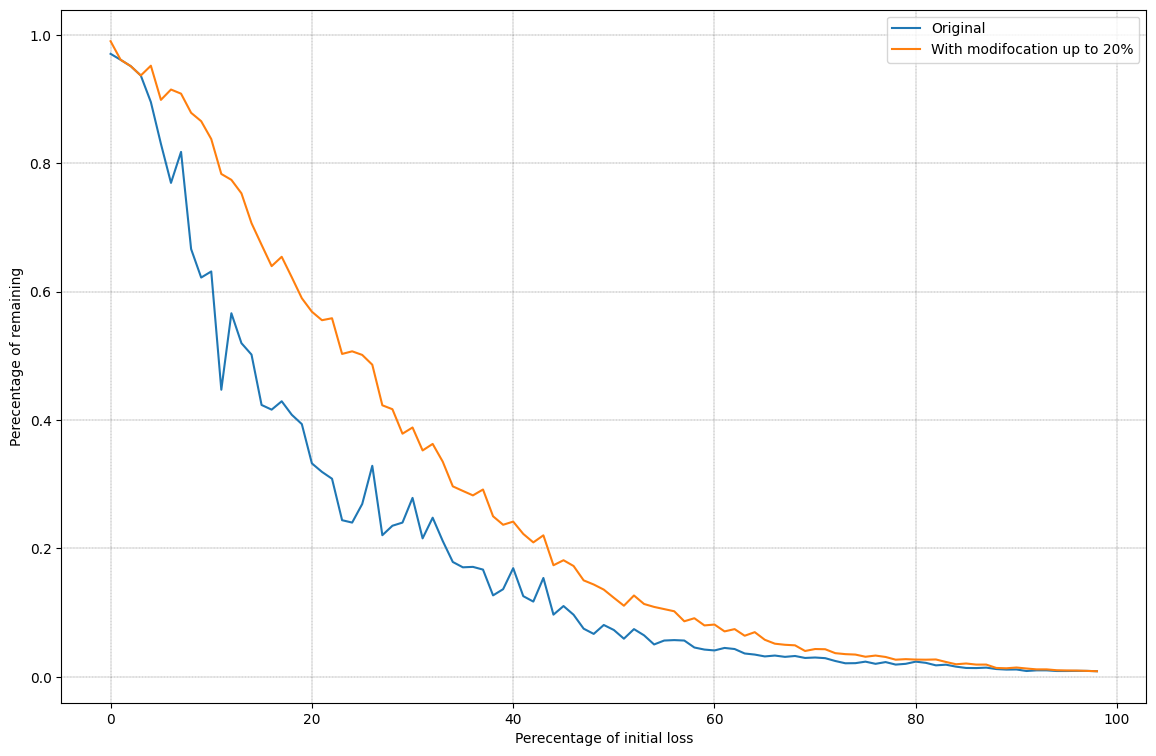

In [870]:
plt.figure(figsize=(14,9))
plt.plot(range(len(k0)),k0,label='Original')
plt.plot(range(len(k0)),k1,label='With modifocation up to 20%')
plt.legend()
plt.xlabel('Perecentage of initial loss')
plt.ylabel('Perecentage of remaining')
plt.grid(color='black', linestyle='--', linewidth=0.2)
plt.savefig('/content/drive/MyDrive/me thesis/bus118_with_20_modify_bat.png',bbox_inches='tight')

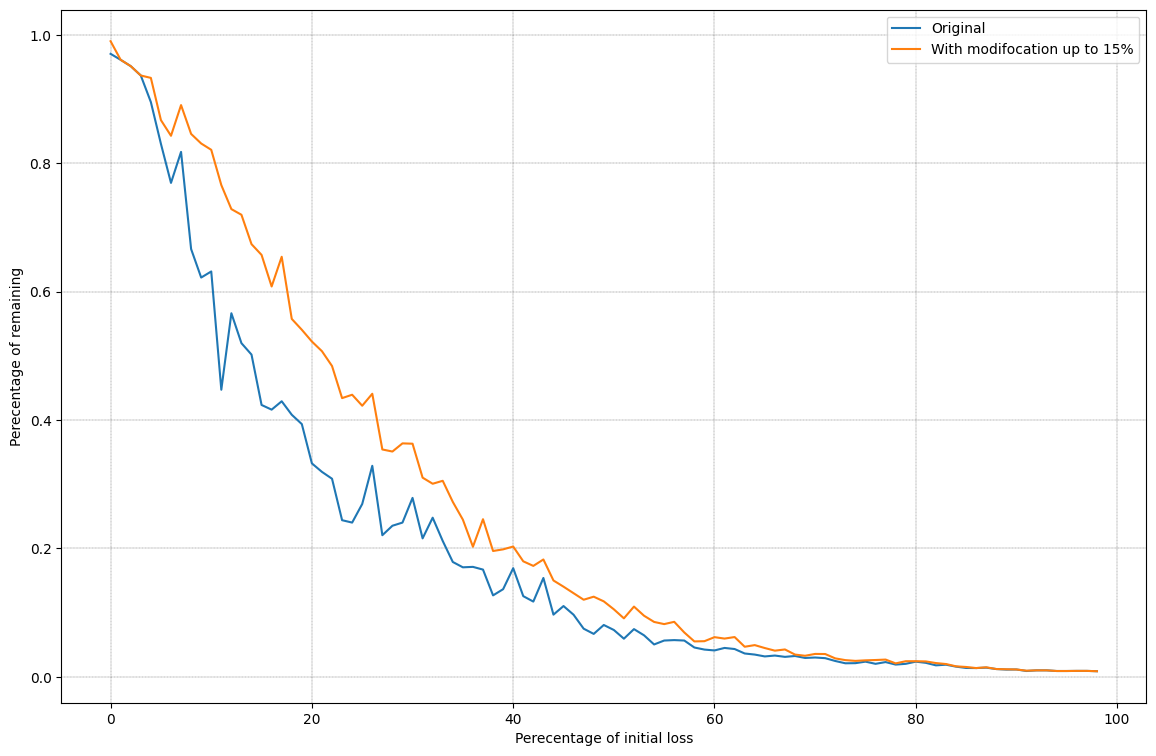

In [788]:
plt.figure(figsize=(14,9))
plt.plot(range(len(k0)),k0,label='Original')
plt.plot(range(len(k0)),k1,label='With modifocation up to 15%')
plt.legend()
plt.xlabel('Perecentage of initial loss')
plt.ylabel('Perecentage of remaining')
plt.grid(color='black', linestyle='--', linewidth=0.2)
plt.savefig('/content/drive/MyDrive/me thesis/bus118_with_15_modify.png',bbox_inches='tight')

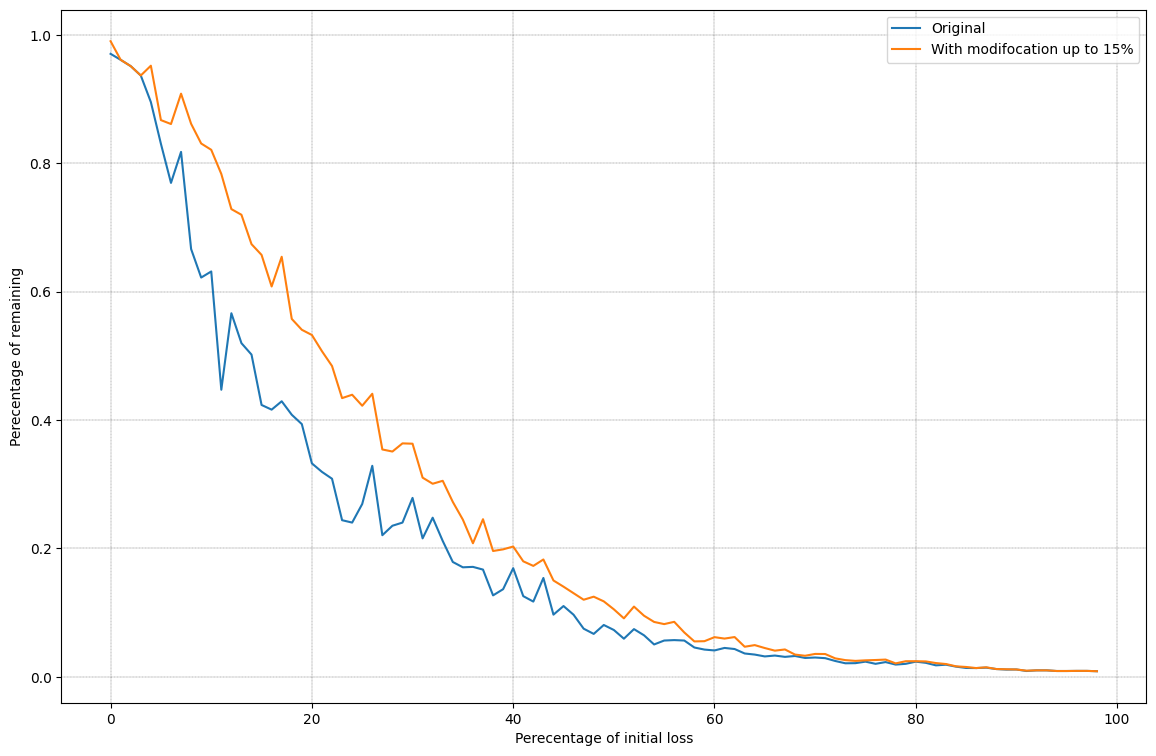

In [843]:
plt.figure(figsize=(14,9))
plt.plot(range(len(k0)),k0,label='Original')
plt.plot(range(len(k0)),k1,label='With modifocation up to 15%')
plt.legend()
plt.xlabel('Perecentage of initial loss')
plt.ylabel('Perecentage of remaining')
plt.grid(color='black', linestyle='--', linewidth=0.2)
plt.savefig('/content/drive/MyDrive/me thesis/bus118_with_15_modify.png',bbox_inches='tight')

In [799]:
b5 = pd.read_csv('/content/drive/MyDrive/me thesis/bus118_with_5_modify.csv')
b5 = b5['With modifocation']

In [804]:
b10 = pd.read_csv('/content/drive/MyDrive/me thesis/bus118_with_10_modify.csv')
b10 = b10[b10.columns[1]]

In [805]:
# b5.columns

In [806]:
b15 = pd.read_csv('/content/drive/MyDrive/me thesis/bus118_with_15_modify.csv')
b15 = b15[b15.columns[1]]

In [807]:
b20 = pd.read_csv('/content/drive/MyDrive/me thesis/bus118_with_20_modify.csv')
b20 = b20[b20.columns[1]]

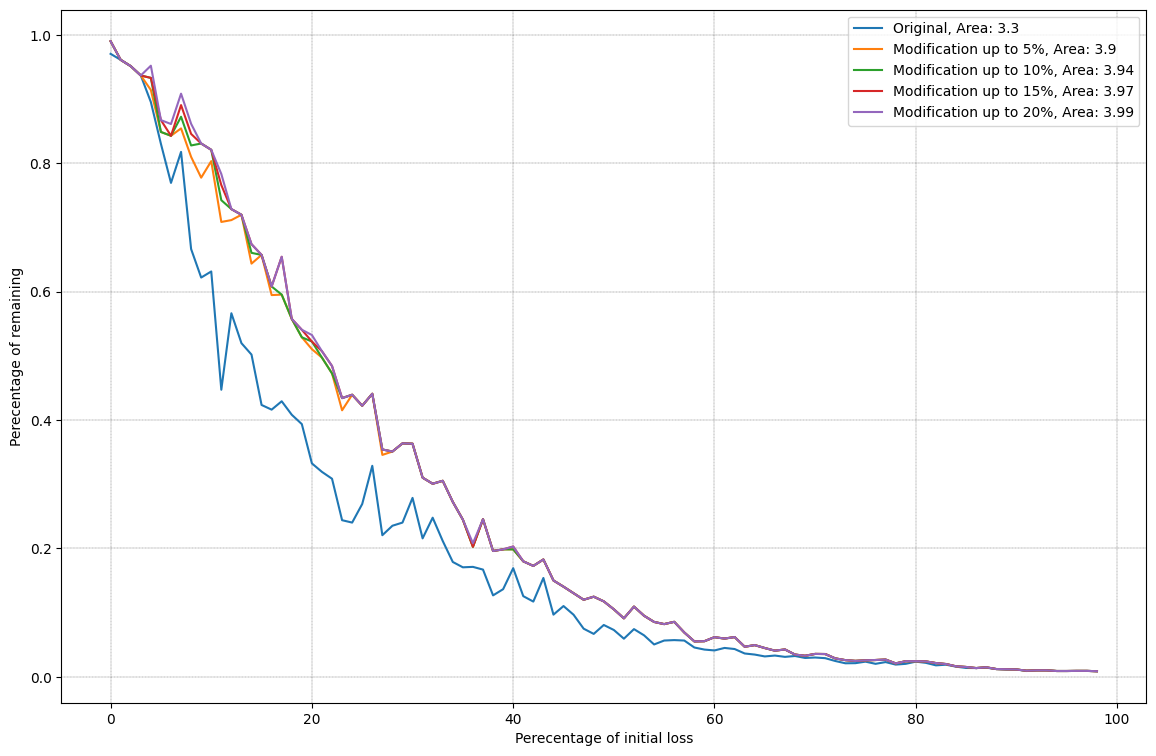

In [842]:
plt.figure(figsize=(14,9))
plt.plot(range(len(k0)),k0,label=f'Original, Area: {np.sqrt(np.sum((k0-k_0)**2)):.3}')
plt.plot(range(len(k0)),b5,label=f'Modification up to 5%, Area: {np.sqrt(np.sum((b5-k_0)**2)):.3}')
plt.plot(range(len(k0)),b10,label=f'Modification up to 10%, Area: {np.sqrt(np.sum((b10-k_0)**2)):.3}')
plt.plot(range(len(k0)),b15,label=f'Modification up to 15%, Area: {np.sqrt(np.sum((b15-k_0)**2)):.3}')
plt.plot(range(len(k0)),b20,label=f'Modification up to 20%, Area: {np.sqrt(np.sum((b20-k_0)**2)):.3}')

plt.legend()
plt.xlabel('Perecentage of initial loss')
plt.ylabel('Perecentage of remaining')
plt.grid(color='black', linestyle='--', linewidth=0.2)
plt.savefig('/content/drive/MyDrive/me thesis/bus118_with_0_5_10_15_20_modify.png',bbox_inches='tight')

In [811]:
# np.sqrt(np.array(b5)**2 - np.array(k0)**2)

<ipython-input-811-ad080e1a2d1f>:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(np.array(b5)**2 - np.array(k0)**2)


array([1.96338796e-01,            nan, 1.49011612e-08, 0.00000000e+00,
       1.84516029e-01, 1.76129588e-01, 3.43993855e-01, 2.47426049e-01,
       4.60387687e-01, 4.66666653e-01, 4.96599294e-01, 5.49645102e-01,
       4.30596548e-01, 4.97927910e-01, 4.02925242e-01, 5.02618338e-01,
       4.24783264e-01, 4.12567580e-01, 3.79782782e-01, 3.53271410e-01,
       3.87342836e-01, 3.81220315e-01, 3.58043777e-01, 3.35956831e-01,
       3.67953766e-01, 3.25368242e-01, 2.93900651e-01, 2.66182434e-01,
       2.60362375e-01, 2.73012496e-01, 2.32791782e-01, 2.23062181e-01,
       1.70358461e-01, 2.20156574e-01, 2.05534456e-01, 1.75648836e-01,
       1.08301637e-01, 1.79964965e-01, 1.49465004e-01, 1.44212091e-01,
       1.03872588e-01, 1.28777872e-01, 1.27009671e-01, 9.85327580e-02,
       1.14681027e-01, 8.69939093e-02, 8.73037669e-02, 9.38242381e-02,
       1.05459147e-01, 8.54390288e-02, 7.57761714e-02, 6.91066232e-02,
       8.03244999e-02, 6.98667012e-02, 6.91020504e-02, 5.96044127e-02,
      

In [818]:
np.array(b5)

array([0.99016949, 0.96118644, 0.95135593, 0.93677966, 0.91423729,
       0.84881356, 0.84288136, 0.85440678, 0.81      , 0.77762712,
       0.80338983, 0.70864407, 0.71152542, 0.71983051, 0.64372881,
       0.65728814, 0.59474576, 0.59542373, 0.55762712, 0.52898305,
       0.51050847, 0.49728814, 0.47271186, 0.41525424, 0.43949153,
       0.42237288, 0.44101695, 0.34576271, 0.35101695, 0.36372881,
       0.36322034, 0.31033898, 0.30084746, 0.30542373, 0.27254237,
       0.24491525, 0.20271186, 0.24559322, 0.19610169, 0.19864407,
       0.19864407, 0.18      , 0.17288136, 0.18288136, 0.15016949,
       0.14050847, 0.13033898, 0.12016949, 0.12491525, 0.11762712,
       0.10525424, 0.09118644, 0.10949153, 0.09525424, 0.08559322,
       0.08220339, 0.08576271, 0.06915254, 0.05525424, 0.05559322,
       0.06186441, 0.05966102, 0.0620339 , 0.04694915, 0.04949153,
       0.04491525, 0.04084746, 0.04271186, 0.03474576, 0.03288136,
       0.03576271, 0.03559322, 0.02881356, 0.02610169, 0.02491

In [822]:
np.sqrt(np.sum((np.array(b5)-np.array(k0))**2))

0.843797587952271

In [836]:
k_0 = np.zeros_like(k0)

In [826]:
b5,k0 = np.array(b5),np.array(k0)

In [828]:
b10 = np.array(b10)
b15 = np.array(b15)
b20 = np.array(b20)

In [838]:
np.sqrt(np.sum((k0-k_0)**2))

3.2970635041876832

In [844]:
f = pd.DataFrame()
f['m0'] = k0
f['m5'] = b5
f['m10'] = b10
f['m15'] = b15
f['m20'] = b20


In [846]:
f.to_csv('/content/drive/MyDrive/me thesis/final_output.csv',index=False)

In [847]:
f = pd.read_csv('/content/drive/MyDrive/me thesis/final_output.csv')
k0 = f['m0']
b5 = f['m5']
b10 = f['m10']
b15 = f['m15']
b20 = f['m20']


In [856]:
print(f'm{1:>10}m')

m         1m


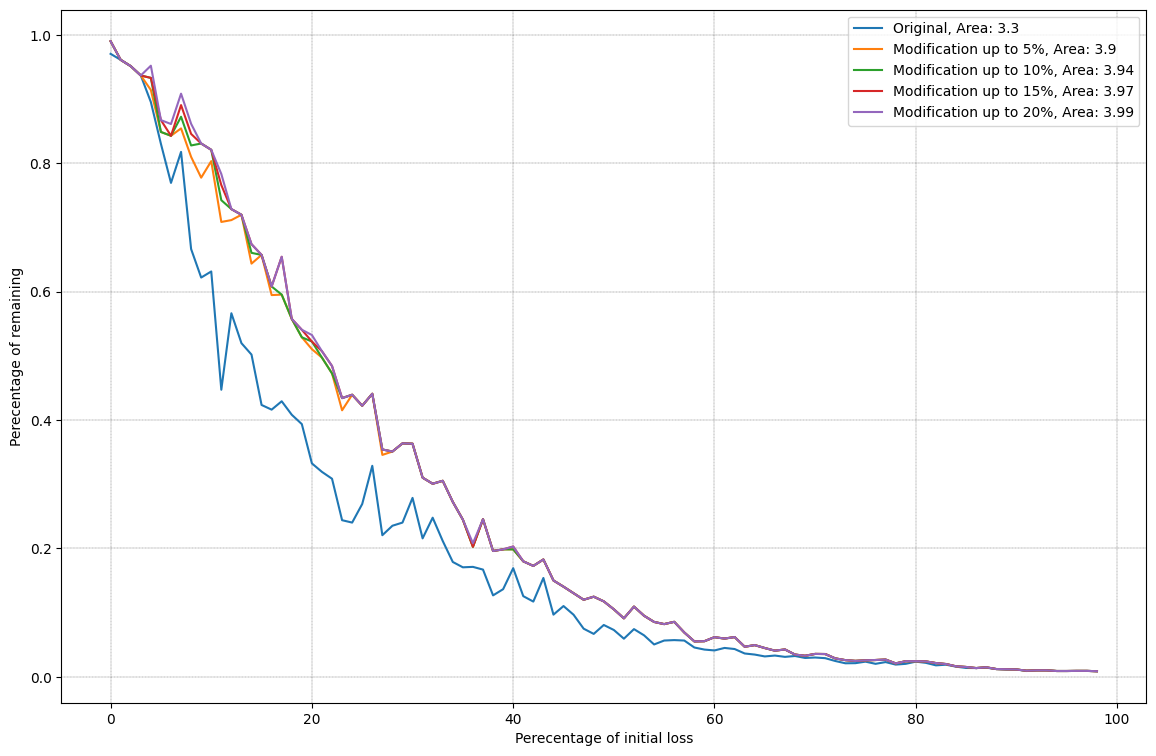

In [859]:
plt.figure(figsize=(14,9))
plt.plot(range(len(k0)),k0,label=f'Original, Area: {np.sqrt(np.sum((k0-k_0)**2)):.3}')
plt.plot(range(len(k0)),b5,label=f'Modification up to 5%, Area: {np.sqrt(np.sum((b5-k_0)**2)):.3}')
plt.plot(range(len(k0)),b10,label=f'Modification up to 10%, Area: {np.sqrt(np.sum((b10-k_0)**2)):.3}')
plt.plot(range(len(k0)),b15,label=f'Modification up to 15%, Area: {np.sqrt(np.sum((b15-k_0)**2)):.3}')
plt.plot(range(len(k0)),b20,label=f'Modification up to 20%, Area: {np.sqrt(np.sum((b20-k_0)**2)):.3}')

plt.legend()
plt.xlabel('Perecentage of initial loss')
plt.ylabel('Perecentage of remaining')
plt.grid(color='black', linestyle='--', linewidth=0.2)
plt.savefig('/content/drive/MyDrive/me thesis/bus118_with_0_5_10_15_20_modify.png',bbox_inches='tight')